# GoEmotions No Context Evaluation

In [1]:
from transformers import AutoTokenizer, BertForSequenceClassification
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from ast import literal_eval
from collections import Counter
from scipy.stats import entropy

In [2]:
sns.set(rc={'figure.figsize':(12, 8)})

## Data

In [3]:
#!wget https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/emotions.txt

## Preparations

In [4]:
labels_df = pd.read_csv('emotions.txt', header=None)
ID_TO_EMOTION = dict(labels_df[0])
EMOTION_TO_ID = {emotion: emotion_id for emotion_id, emotion in ID_TO_EMOTION.items()}

In [5]:
GPT_EVALUTION_FILE_PATH = "datasets/Ewaluacja ChatGPT - zadania - GoEmotion Personalized Without Context.csv"

In [6]:
gpt_evaluation_df = pd.read_csv(GPT_EVALUTION_FILE_PATH)

## Statystyki

In [7]:
gpt_evaluation_df["annotation"] = gpt_evaluation_df["annotation"].apply(literal_eval)
counter = Counter(
    gpt_evaluation_df["annotation"].sum()
)
print(max(counter.values()), min(counter.values()))
print(entropy(list(counter.values())))

288 6
2.982637337506349


## Preprocessing

### # Cases required manual correction)

In [8]:
len(gpt_evaluation_df.query("chatgpt_final != chatgpt_raw"))

1

### Correct invalid response format

In [9]:
for idx, evaluation in enumerate(gpt_evaluation_df["chatgpt_final"]):
    try:
        literal_eval(evaluation)
    except Exception:
        print(idx, evaluation)

67 nan


In [10]:
gpt_evaluation_df.loc[67, "chatgpt_final"] = 'None'

In [11]:
gpt_evaluation_df["chatgpt_final"] = gpt_evaluation_df["chatgpt_final"].apply(literal_eval)

### Filet our cases where GPT gave no answer

In [12]:
print(len(gpt_evaluation_df))
gpt_evaluation_df = gpt_evaluation_df.dropna(subset=["chatgpt_final"])
print(len(gpt_evaluation_df))

1151
1150


### Filter out cases where GPT gave invalid answer
* In cases where GPT gave invalid answer (e.g. label with spelling mistake) we need to filter them out)

In [13]:
unique_gpt_answers = set()
for evaluation in gpt_evaluation_df["chatgpt_final"]:
    unique_gpt_answers = unique_gpt_answers.union(set(evaluation))

In [14]:
len(unique_gpt_answers)

46

In [15]:
is_valid_label_map = {
    label: label in EMOTION_TO_ID
    for label in unique_gpt_answers
}

In [16]:
print(len(gpt_evaluation_df))
gpt_evaluation_df = gpt_evaluation_df.loc[
    gpt_evaluation_df["chatgpt_final"].apply(
        lambda labels: all((is_valid_label_map[label] for label in labels))
    )
]
print(len(gpt_evaluation_df))

1150
1123


## Encode model predictions

In [17]:
def encode_one_hot(annotations: list[str]):
    one_hot = np.zeros(len(ID_TO_EMOTION), dtype="bool")
    for emotion in annotations:
        one_hot[EMOTION_TO_ID[emotion]] = 1
    return one_hot

gpt_evaluation_df["true_labels"] =  gpt_evaluation_df["annotation"].apply(
    encode_one_hot
)

In [18]:
gpt_evaluation_df["gpt_labels"] =  gpt_evaluation_df["chatgpt_final"].apply(encode_one_hot)

## Obtain model predictions

### Load pretrained model

In [19]:
tokenizer = AutoTokenizer.from_pretrained("monologg/bert-base-cased-goemotions-original")
model = BertForSequenceClassification.from_pretrained("monologg/bert-base-cased-goemotions-original")

### Add annotator ID as special tokens

In [20]:
special_tokens_map = {
    "additional_special_tokens": []
}
for rater_id in gpt_evaluation_df["rater_id"].unique():
    special_tokens_map["additional_special_tokens"].append(f"<{rater_id}>")
tokenizer.add_special_tokens(special_tokens_map)

81

In [21]:
model.resize_token_embeddings(len(tokenizer))

Embedding(29077, 768)

In [22]:
gpt_evaluation_df["text_with_special_tokens"] = gpt_evaluation_df.apply(
    lambda row: f"<{row.rater_id}> {row.text}",
    axis=1,
)

In [23]:
gpt_evaluation_df["text_with_special_tokens"].head(2)

0    <0> That’s how I outfitted my team in that awe...
1        <0> All I want for Christmas is a broken home
Name: text_with_special_tokens, dtype: object

### Get model predictions

In [24]:
def get_model_predictions(text: str) -> np.ndarray:
    inputs = tokenizer(text, return_tensors="pt")
    logits = model(**inputs).logits
    return (torch.sigmoid(logits).squeeze(dim=0) > 0.5).numpy()

In [25]:
gpt_evaluation_df["sota_labels"] = gpt_evaluation_df["text_with_special_tokens"].apply(
    get_model_predictions
)

## Evaluation

### SOTA

In [26]:
accuracy_score(
    y_true=np.array(gpt_evaluation_df["true_labels"].tolist()),
    y_pred=np.array(gpt_evaluation_df["sota_labels"].tolist()),
)

0.346393588601959

In [27]:
f1_score(
    y_true=np.array(gpt_evaluation_df["true_labels"].tolist()),
    y_pred=np.array(gpt_evaluation_df["sota_labels"].tolist()),
    average='macro',
)

0.347785110699626

### GPT

In [28]:
accuracy_score(
    y_true=np.array(gpt_evaluation_df["true_labels"].tolist()),
    y_pred=np.array(gpt_evaluation_df["gpt_labels"].tolist()),
)

0.195013357079252

In [29]:
f1_score(
    y_true=np.array(gpt_evaluation_df["true_labels"].tolist()),
    y_pred=np.array(gpt_evaluation_df["gpt_labels"].tolist()),
    average='macro',
)

0.2373781852679125

## Per class metrics

In [30]:
metrics = []
for emotion, emotion_id in EMOTION_TO_ID.items():
    true_labels = gpt_evaluation_df["true_labels"].apply(lambda labels: labels[emotion_id]).values
    sota_labels = gpt_evaluation_df["sota_labels"].apply(lambda labels: labels[emotion_id]).values
    gpt_labels = gpt_evaluation_df["gpt_labels"].apply(lambda labels: labels[emotion_id]).values
    metrics.append(
        {
            "Emotion": emotion,
            "Emotion ID": emotion_id,
            "Accuracy": accuracy_score(
                y_true=true_labels,
                y_pred=sota_labels,
            ),
            "F1Score": f1_score(
                y_true=true_labels,
                y_pred=sota_labels,
            ),
            "Model": "SOTA",
        }
    )
    metrics.append(
        {
            "Emotion": emotion,
            "Emotion ID": emotion_id,
            "Accuracy": accuracy_score(
                y_true=true_labels,
                y_pred=gpt_labels,
            ),
            "F1Score": f1_score(
                y_true=true_labels,
                y_pred=gpt_labels,
            ),
            "Model": "GPT",
        }
    )
metrics_df = pd.DataFrame(metrics)

In [31]:
metrics_df[metrics_df["Model"] == "GPT"]["F1Score"].tolist()

[0.25925925925925924,
 0.39779005524861877,
 0.2898550724637681,
 0.19718309859154928,
 0.16923076923076924,
 0.17241379310344826,
 0.3,
 0.2764227642276423,
 0.2352941176470588,
 0.24509803921568632,
 0.20987654320987653,
 0.19753086419753088,
 0.10526315789473684,
 0.18666666666666668,
 0.2424242424242424,
 0.48484848484848486,
 0.5,
 0.2033898305084746,
 0.36923076923076925,
 0.0,
 0.2191780821917808,
 0.11764705882352941,
 0.20895522388059704,
 0.058823529411764705,
 0.11764705882352941,
 0.3777777777777778,
 0.22222222222222224,
 0.282560706401766]

In [32]:
metrics_df[metrics_df["Model"] == "SOTA"]["F1Score"].tolist()

[0.5517241379310345,
 0.7818181818181817,
 0.4835164835164836,
 0.27058823529411763,
 0.2567567567567567,
 0.23728813559322035,
 0.35294117647058826,
 0.37254901960784315,
 0.20689655172413793,
 0.2291666666666667,
 0.2909090909090909,
 0.30434782608695654,
 0.25,
 0.24000000000000005,
 0.4444444444444445,
 0.7969924812030074,
 0.0,
 0.360655737704918,
 0.7010309278350516,
 0.0,
 0.2637362637362637,
 0.16666666666666666,
 0.16901408450704225,
 0.0,
 0.5217391304347826,
 0.5135135135135135,
 0.4333333333333333,
 0.5383542538354255]

[Text(0.5, 1.0, 'SOTA scores for GoEmotions Personalized No Context')]

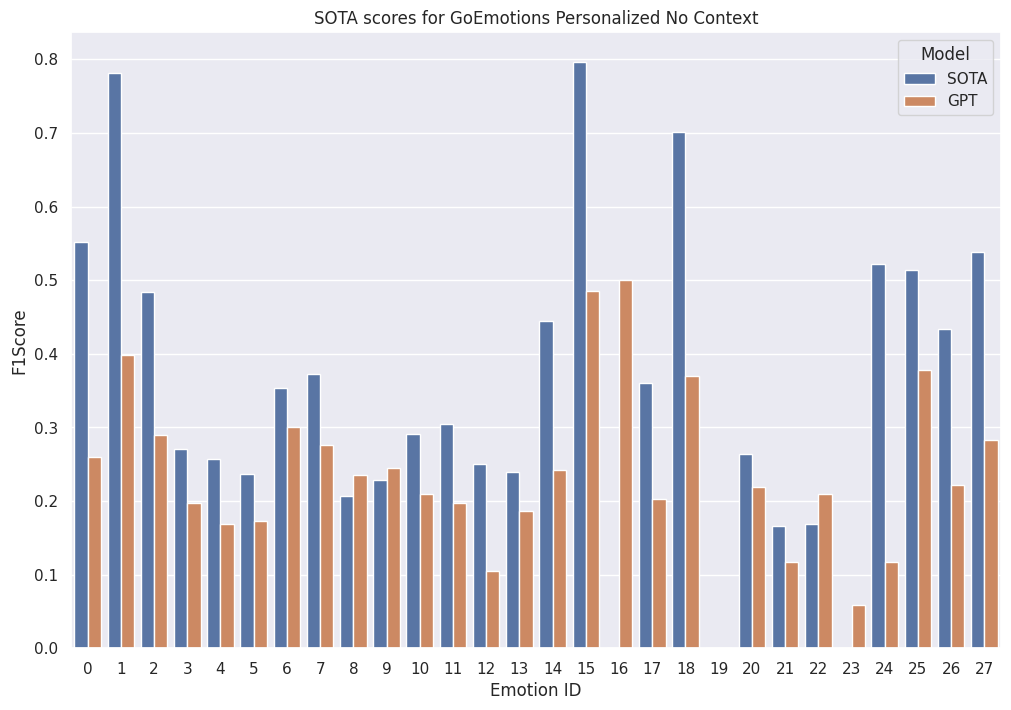

In [33]:
fig = sns.barplot(
    data=metrics_df,
    x="Emotion ID",
    y="F1Score",
    hue="Model",
).set(title="SOTA scores for GoEmotions Personalized No Context")
#plt.xticks(rotation=45)
fig

## Biggest model mistakes

In [34]:
gpt_evaluation_df["sota_annotation"] = gpt_evaluation_df["sota_labels"].apply(
    lambda labels: [
        ID_TO_EMOTION[idx]
        for idx, value in enumerate(labels)
        if value
    ]
)

In [35]:
def compute_model_score(predictions, annotations) -> int:
    predictions = set(predictions)
    annotations = set(annotations)
    n_correct = len(predictions & annotations)
    n_incorrect = len(predictions ^ annotations)
    return n_correct - n_incorrect

In [36]:
gpt_evaluation_df["gpt_score"] = gpt_evaluation_df.apply(
    lambda row: compute_model_score(row.chatgpt_final, row.annotation),
    axis=1,
)
gpt_evaluation_df["sota_score"] = gpt_evaluation_df.apply(
    lambda row: compute_model_score(row.sota_annotation, row.annotation),
    axis=1,
)
gpt_evaluation_df = gpt_evaluation_df.sort_values("gpt_score")

## Save results

In [37]:
metrics_df.to_csv("results/goemotions/metrics/no_context.csv")
gpt_evaluation_df.to_csv("results/goemotions/data/no_context.csv", sep=";")
# Best & Worst GPT predictions
columns = ["text", "prompt", "annotation", "gpt_score", "sota_score", "chatgpt_final", "sota_labels"]
gpt_evaluation_df[columns].head(10).to_csv("results/goemotions/worst/no_context.csv", sep=";")
gpt_evaluation_df[columns].tail(10).to_csv("results/goemotions/best/no_context.csv", sep=";")